In [ ]:
!pip install git+https://github.com/amazon-science/chronos-forecasting.git
!pip install chronos-forecasting
!pip install transformers

  Cloning https://github.com/amazon-science/chronos-forecasting.git to /tmp/pip-req-build-b8o5heo6
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /tmp/pip-req-build-b8o5heo6
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit 133761a90145f77971a08c49bfc7cca318b2df9b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

from chronos import BaseChronosPipeline, ChronosPipeline

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

## Amazon chronos-bolt-base

In [ ]:
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-bolt-base",
    device_map="cuda",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    torch_dtype=torch.bfloat16,
)

In [ ]:
df = pd.read_csv('Mastercard_stock_history.csv')
train_df = df[:-100]
test_df = df[-100:]

In [ ]:
context = torch.tensor(train_df["Close"])
prediction_length = 100
forecast = pipeline.predict(context, prediction_length)  # shape [num_series, num_samples, prediction_length]

/usr/local/lib/python3.10/dist-packages/chronos/chronos_bolt.py:477: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


In [ ]:
forecast_index = range(len(train_df), len(train_df) + prediction_length)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

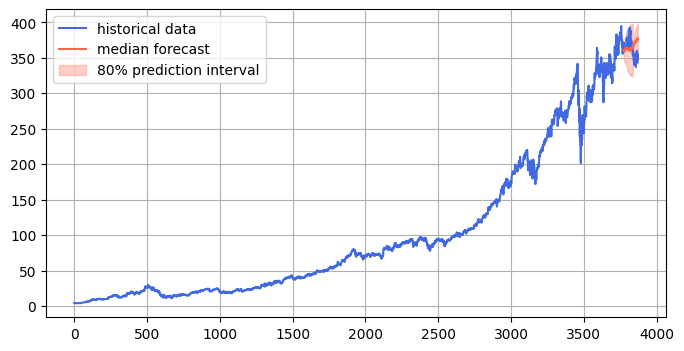

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(df["Close"], color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# use median value to calculate RMSE
mse = np.mean((test_df["Close"] - median)**2)
print(f"RMSE is: {np.sqrt(mse): .2f}")

RMSE is:  17.47


## Amazon chronos-bolt-large

In [ ]:
pipeline = ChronosPipeline.from_pretrained(
  "amazon/chronos-t5-large",
  device_map="cuda",
  torch_dtype=torch.bfloat16,
)

In [ ]:
pipeline.tokenizer

In [ ]:
context = torch.tensor(train_df["Close"])
prediction_length = 100
forecast = pipeline.predict(context, prediction_length)  # shape [num_series, num_samples, prediction_length]

forecast_index = range(len(train_df), len(train_df) + prediction_length)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

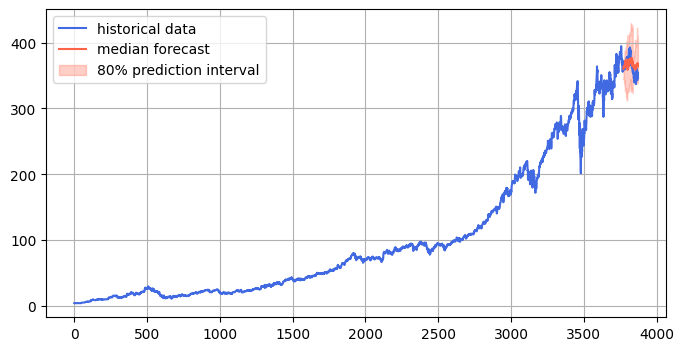

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(df["Close"], color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# use median value to calculate RMSE
mse = np.mean((test_df["Close"] - median)**2)
print(f"RMSE is: {np.sqrt(mse): .2f}")

RMSE is:  12.40


In [ ]:
train_df = train_df[["Close"]]
test_df = test_df[["Close"]]

## Finetune the large model

In [ ]:
model_name = "amazon/chronos-t5-large"
base_model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# Freeze all parameters in the base model
for param in base_model.parameters():
    param.requires_grad = False

In [ ]:
class EnhancedChronosModel(nn.Module):
    def __init__(self, base_model, hidden_size=1024, num_classes=1):
        super().__init__()
        self.base_model = base_model

        # Add custom layers on top of the base model
        self.additional_layers = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, num_classes),  # Adjust output size based on task
        )

    def forward(self, input_ids, attention_mask):
        # Pass inputs through the base model
        base_output = self.base_model.encoder(input_ids=input_ids, attention_mask=attention_mask)

        # Use the last hidden state from the encoder as input to custom layers
        hidden_state = base_output.last_hidden_state[:, 0, :]  # Take [CLS] token's representation
        output = self.additional_layers(hidden_state)
        return output

# Initialize the enhanced model
enhanced_model = EnhancedChronosModel(base_model)
model = enhanced_model.to("cuda")

In [ ]:
train_df_torch = torch.from_numpy(train_df.to_numpy()).type(torch.float32)
test_df_torch = torch.from_numpy(test_df.to_numpy()).type(torch.float32)
X_train = train_df_torch[:, :-1]
X_test = test_df_torch[:, :-1]

In [ ]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
loader = DataLoader(TensorDataset(X_train, y_train), shuffle = False, batch_size = 8)